##                                              **Spread Option Pricing via Monte Carlo Simulations** 
***

A spread option is a complex derivatives contract that derives its value from the difference, or spread, between the prices of two or more assets. In this project we shall try to value the price of a spread call option with the payoff function:

$$ C = max(S_{1} - S_{2} - K, 0)$$

In the current literature, there exists a number of papers trying to tackle the valuation of these derivatives, all with their strenghts and weaknesses. Specifically, Margrabe's formula presented in the paper

- <a href="https://onlinelibrary.wiley.com/doi/10.1111/j.1540-6261.1978.tb03397.x">"The value of an option to exchange one asset for another"(1978)</a>

presents the first closed form solution towards this problem, with the limitation $K = 0$. Following Margrabe, Kirk's approximation extends the formula to include $K > 0$ scenarios. Nevertheless, this analytical solution fails for correlation $\rho$ close to 1. To date, the most precise method for valuating spread option was produced by Bjerksund and Stensland on their paper.

- <a href="https://deliverypdf.ssrn.com/delivery.php?ID=624013110082093071007026027106089011052056061029027087091073064125103065125122067074053002099029105061121075071029068070074066039041082054021078084027127123066029058042034096070005076015097030123098064126094109088097121108097069084030121000095092111&EXT=pdf&INDEX=TRUE">"Closed form spread option valuation(2006)"</a>

All of these papers build upon the Black Scholes Model, and as such are also subject to the limitations of stochastic volatility, transaction costs, and price jumps. I've also found no solution accounting for dividends.

Our approach on this project will be to utilize Monte Carlo Simulations for pricing said call spreads. We will model the dynamics of $S_{1}, S_{2}$  with the following Geometric Brownian Motion equations:

$dS_{1} = {\mu}S_{1}dt + \sigma_{1}S_{1}dz_{1}$

$dS_{2} = {\mu}S_{2}dt + \sigma_{2}S_{2}dz_{2}$

We shall assume constant expected returns, therefore ${\mu} = r$. Furthermore, we will simulate the evolution of the stocks $S_{1}, S_{2}$ over small time increment dt with the following standard expressions:

$S_{1,T} = S_{1}e^{(r- \frac{{\sigma}^{2}_{1}}{2})dt + {\sigma}_{1}\sqrt{dt}Z_{1}},\space Z \thicksim N(0,1)$   
$S_{2,T} = S_{2}e^{(r- \frac{{\sigma}^{2}_{2}}{2})dt + {\sigma}_{2}\sqrt{dt}Z_{2}},\space Z \thicksim N(0,1)$   



In [2]:
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
import time

In [3]:
S1 = 110  # Spot price of first asset
S2 = 100  # Spot price of second asset
K = 10 # Strike price
T = 1     # Time to maturity in years
r = 0.05  # Risk-free interest rate
sigma1 = 0.1  # Volatility of first asset
sigma2 = 0.15  # Volatility of second asset
rho = 0.8    # Correlation between the two assets
M = 100000  # Number of Monte Carlo simulations
N = 100 #Number of timesteps

In [4]:
def  spread_montecarlo(S1, S2, K, T, r, sigma1, sigma2, rho, M, N):

    #Precalculate contants for faster processing
    start = time.time()
    dt = T/N
    nu1dt = (r - 0.5*sigma1**2)*dt
    nu2dt = (r - 0.5*sigma2**2)*dt
    vol1sdt = sigma1*np.sqrt(dt)
    vol2sdt = sigma2*np.sqrt(dt)
    srho = np.sqrt(1-rho**2)

    # Standard Error Placeholders
    sum_CT = 0
    sum_CT2 = 0

    # Monte Carlo Method
    for i in range(M):
        #Return Stock values to T = 0
        St1 = S1
        St2 = S2
        
        for j in range(N):

            #Simulate correlated random paths
            dz1 = np.random.normal()
            dz2 = np.random.normal()
            z1 = dz1
            z2 = rho*dz1 + srho*dz2

            #GBM formula            
            St1 = St1*np.exp(nu1dt + vol1sdt*z1)
            St2 = St2*np.exp(nu2dt + vol2sdt*z2)
        
        #Calculate payoff at time T
        CT = max(St1 - St2 - K,0)

        #Sum up payoffs and squares of payoffs
        sum_CT = sum_CT + CT
        sum_CT2 = sum_CT2 + CT*CT
        
    # Compute Expectation and SE
    C0 = np.exp(-r*T)*sum_CT/M
    sigma = np.sqrt( (sum_CT2 - sum_CT*sum_CT/M)*np.exp(-2*r*T) / (M-1) )
    SE = sigma/np.sqrt(M)

    #timekeeping
    end = time.time()
    print("Regular Monte Carlo Function took:", end - start, "seconds")
    
    return C0, SE

In [5]:
mc_reg_output = spread_montecarlo(S1, S2, K, T, r, sigma1, sigma2, rho, M, N)
print("Call value is ${0} with SE +/- {1}".format(np.round(mc_reg_output[0],5),np.round(mc_reg_output[1],2)))

Regular Monte Carlo Function took: 28.953566312789917 seconds
Call value is $3.8746 with SE +/- 0.02


***
### Monte Carlo Vectorized
Our Monte Carlo simulation took approximately 28 seconds to generate an answer with 10,000 simulations and 1000 timesteps. Surely, this is inefficient for more precise calculations, and is caused by the nested loops within the function, giving us a complexity of O(N*M). Vectorizing the calculations within the function should give us a boost in processing time 

In [6]:
def spread_montecarlo_vec(S1, S2, K, T, r, sigma1, sigma2, rho, M, N):

    #Precalculate constants for faster processing
    start = time.time()
    dt = T/N
    nu1dt = (r - 0.5*sigma1**2)*dt
    nu2dt = (r - 0.5*sigma2**2)*dt
    vol1sdt = sigma1*np.sqrt(dt)
    vol2sdt = sigma2*np.sqrt(dt)
    srho = np.sqrt(1-rho**2)
    
    #Monte Carlo Method

    #Simulate correlated random paths
    dz1 = np.random.normal(size=(N, M)) 
    dz2 = np.random.normal(size=(N, M)) 
    Z1 = dz1
    Z2 = rho*dz1 + srho*dz2

    #Precompute
    delta_St1 = nu1dt + vol1sdt*Z1
    delta_St2 = nu2dt + vol2sdt*Z2

    #GBM Formula
    St1 = S1*np.cumprod( np.exp(delta_St1), axis=0)
    St2 = S2*np.cumprod( np.exp(delta_St2), axis=0)
    ST1 = np.concatenate( (np.full(shape=(1, M), fill_value=S1), St1 ) )
    ST2 = np.concatenate( (np.full(shape=(1, M), fill_value=S2), St2 ) )

    #Calculate payoff at time T
    CT = np.maximum(ST1[-1] - ST2[-1] - K, 0)

    #Compute Expectation and SE
    C0 = np.exp(-r*T)*np.sum(CT)/M
    sigma = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0)**2) / (M-1) )
    SE= sigma/np.sqrt(M)

    #timekeeping
    end = time.time()
    print("Vectorized Monte Carlo Function took:", end - start, "seconds")

    return C0, SE


In [7]:
mc_vec_output = spread_montecarlo_vec(S1, S2, K, T, r, sigma1, sigma2, rho, M, N)
print("Call value is ${0} with SE +/- {1}".format(np.round(mc_vec_output[0],5),np.round(mc_vec_output[1],2)))

Vectorized Monte Carlo Function took: 0.8342878818511963 seconds
Call value is $3.87499 with SE +/- 0.02


***
### Verifying our Results

We've reduced runtime to 0.8 seconds, that's a 97% improvement in speed! Also, our results seem to be within 1 standard deviation from one another, thankfully. Let's compare the price we've got by our Monte Carlo simulation with a closed form solution like Kirk's approximation and Bjerksund and Stensland Formula

In [8]:
#Kirk's Approximation
def kirksA(f1, f2, x, t, r, v1, v2, corr, type = "c"):
    # Compute F and Sigma
    f = f1 / (f2 + x)
    f_temp = f2 / (f2 + x)
    v = math.sqrt((v1 ** 2) + ((v2 * f_temp) ** 2) - (2 * corr * v1 * v2 * f_temp))

    #Compute d1 and d2
    d1 = (math.log(f) + 0.5*t*v**2) / (v * math.sqrt(t))
    d2 = d1 - v * math.sqrt(t)

    #Apply formula
    if type == 'c':
          price = math.exp(-r*t)*( f1 * norm.cdf(d1) - (f2 + x)*norm.cdf(d2))
    elif type == 'p':
          price = (f2 + x)*math.exp(-r*t)*( norm.cdf(-d2) - f*norm.cdf(-d1))

    return price

In [9]:
def bjerk_stens(f1, f2, K, t, r, v1, v2, rho, type = 'c'):
    #Compute variables and Sigma
    N = norm.cdf
    a = f2 + K
    b = f2/(a)
    v = math.sqrt(v1**2 - 2*b*rho*v1*v2 + b**2*v2**2)

    #Compute d1, d2, and d3
    d1 = (math.log(f1/a) + (0.5*v1**2 - b*rho*v1*v2 + 0.5*b**2*v2**2)*t)/v*math.sqrt(t)
    d2 = (math.log(f1/a) + (-0.5*v1**2 + rho*v1*v2 + 0.5*b**2*v2**2 - b*v2**2)*t)/v*math.sqrt(t)
    d3 = (math.log(f1/a) + (-0.5*v1**2 + 0.5*b**2*v2**2)*t)/v*math.sqrt(t)

    if type == 'c':
        price = math.exp(-r*t)*(f1*N(d1) - f2*N(d2) - K*N(d3))
    if type == 'p':
        price = math.exp(-r*t)*(f1*(N(d1) - 1) - f2*(N(d2) - 1) - K*(N(d3) - 1))

    return price

In [10]:
#Play with the values and test the code. For rho -> 1.0 Kirk's Approximation becomes less and less accurate.

S1 = 110  # Spot price of first asset
S2 = 100  # Spot price of second asset
K = 10 # Strike price
T = 1     # Time to maturity in years
r = 0.05  # Risk-free interest rate
sigma1 = 0.1  # Volatility of first asset
sigma2 = 0.15  # Volatility of second asset
rho = 0.8    # Correlation between the two assets
M = 1000000  # Number of Monte Carlo simulations
N = 10 #Number of timesteps

Vectorized Monte Carlo Function took: 0.8213562965393066 seconds
Monte Carlo Simulation Call price: $3.87299 with SE +/- 0.01
-------------------------------------------------------
Kirk's Approximation Call price: 3.8709
Bjerksund & Stensland Call price: 3.8716


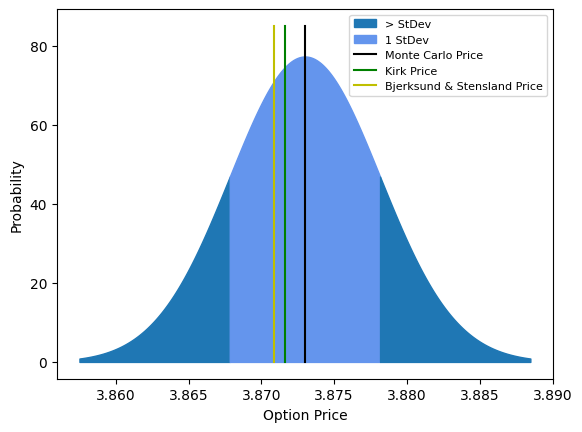

In [11]:
#Calculating forward prices
F1 = S1*math.exp(r*T)
F2 = S2*math.exp(r*T)

#MonteCarlo
mc_vec_output = spread_montecarlo_vec(S1, S2, K, T, r, sigma1, sigma2, rho, M, N)

print("Monte Carlo Simulation Call price: ${0} with SE +/- {1}".format(np.round(mc_vec_output[0],5),np.round(mc_vec_output[1],2)))
print("-------------------------------------------------------")
print("Kirk's Approximation Call price: %.4f" % round(kirksA(F1, F2, K, T, r, sigma1, sigma2, rho, 'c'), 4))
print("Bjerksund & Stensland Call price: %.4f" % round(bjerk_stens(F1, F2, K, T, r, sigma1, sigma2, rho, 'c'), 4))

#Visualising everything
C0, SE = mc_vec_output
bjerk_stens_val = bjerk_stens(F1, F2, K, T, r, sigma1, sigma2, rho, 'c')
kirksA_val = kirksA(F1, F2, K, T, r, sigma1, sigma2, rho, 'c')

x1 = np.linspace(C0-3*SE, C0-1*SE, 100)
x2 = np.linspace(C0-1*SE, C0+1*SE, 100)
x3 = np.linspace(C0+1*SE, C0+3*SE, 100)

s1 = norm.pdf(x1, C0, SE)
s2 = norm.pdf(x2, C0, SE)
s3 = norm.pdf(x3, C0, SE)

plt.fill_between(x1, s1, color='tab:blue',label='> StDev')
plt.fill_between(x2, s2, color='cornflowerblue',label='1 StDev')
plt.fill_between(x3, s3, color='tab:blue')

plt.plot([C0,C0],[0, max(s2)*1.1], 'k',
        label='Monte Carlo Price')
plt.plot([bjerk_stens_val, bjerk_stens_val],[0, max(s2)*1.1], 'g',
        label='Kirk Price')
plt.plot([kirksA_val, kirksA_val],[0, max(s2)*1.1], 'y',
        label='Bjerksund & Stensland Price')

plt.ylabel("Probability")
plt.xlabel("Option Price")
plt.legend(loc='upper right', fontsize='8')
plt.show()
